In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import metrics
from keras import regularizers
from keras.datasets import fashion_mnist
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

x_train = train_images[10000:]
x_validation = train_images[:10000]

y_train = train_labels[10000:]
y_validation = train_labels[:10000]

In [10]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator


paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])
padded_image_train = tf.pad(train_images, paddings, "CONSTANT") 
padded_image_test = tf.pad(test_images, paddings, "CONSTANT") 


converted_train = tf.image.grayscale_to_rgb(padded_image_train)
converted_test = tf.image.grayscale_to_rgb(padded_image_test)


x_train = converted_train[10000:]
x_validation = converted_train[:10000]

y_train = train_labels[10000:]
y_validation = train_labels[:10000]


conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

modified_model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(1024, activation="leaky_relu", kernel_regularizer=regularizers.L2(0.001)),
   layers.Dense(10, activation="sigmoid"),
])

early_stopping = EarlyStopping(patience=10, monitor='val_accuracy')
checkpoint = ModelCheckpoint('best_model_vgg16.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

modified_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-5),
    # optimizer="adam",
    metrics=["accuracy"]
)

history = modified_model.fit(
    x_train, 
    y_train, 
    epochs=40,
    # batch_size=1024,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpoint, early_stopping]

)

test_loss, test_accuracy = modified_model.evaluate(converted_test, test_labels)
print(f"Test loss: {test_loss}, test accuracy: {test_accuracy}")


Epoch 1/40
1563/1563 [==============================] - ETA: 0s - loss: 1.1360 - accuracy: 0.8271
Epoch 1: val_accuracy improved from -inf to 0.87350, saving model to best_model_vgg16.keras
1563/1563 [==============================] - 63s 39ms/step - loss: 1.1360 - accuracy: 0.8271 - val_loss: 0.9375 - val_accuracy: 0.8735
Epoch 2/40
1562/1563 [============================>.] - ETA: 0s - loss: 0.8859 - accuracy: 0.8816
Epoch 2: val_accuracy improved from 0.87350 to 0.88030, saving model to best_model_vgg16.keras
1563/1563 [==============================] - 60s 39ms/step - loss: 0.8858 - accuracy: 0.8817 - val_loss: 0.8547 - val_accuracy: 0.8803
Epoch 3/40
1562/1563 [============================>.] - ETA: 0s - loss: 0.8072 - accuracy: 0.8931
Epoch 3: val_accuracy improved from 0.88030 to 0.89230, saving model to best_model_vgg16.keras
1563/1563 [==============================] - 60s 38ms/step - loss: 0.8071 - accuracy: 0.8931 - val_loss: 0.7940 - val_accuracy: 0.8923
Epoch 4/40
1563/156

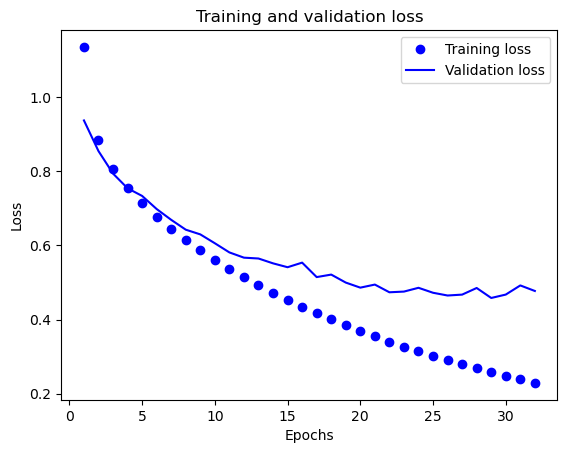

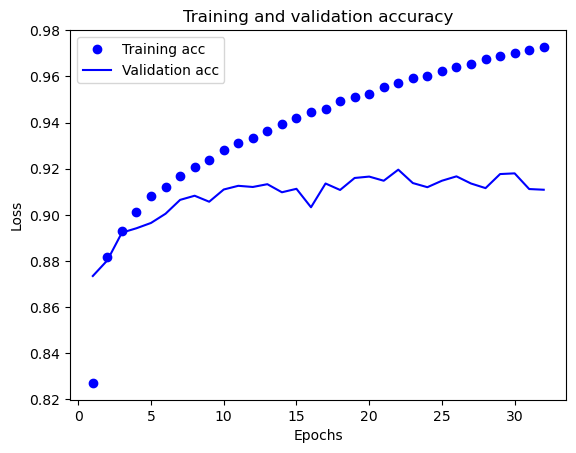

In [11]:
history = history.history
loss_values = history['loss']
val_loss_values = history['val_loss']

epochs = range(1, len(history['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history['val_accuracy']
plt.plot(epochs, history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
За допомогою згорткових мереж VGG16 вдалось досягнути покращення з 0.9047 до 0.9090.